In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import mlflow


from preprocessor.data_preprocessor import LeadScoringPreprocessor

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, roc_auc_score, precision_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, classification_report, roc_curve

from xgboost import XGBClassifier

## 1. Load Data

In [2]:
df = pd.read_csv('data/lead_scoring.csv')

In [3]:
X = df.drop('Converted', axis=1)
y = df['Converted']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 2. Preprocess Data

In [5]:
preprocessor = LeadScoringPreprocessor()
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity', 'Specialization', 'What is your current occupation']
['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']


## 3. Modelling

In [6]:
skfold = StratifiedKFold(5, shuffle=True, random_state=12)

### Training Utils

In [7]:
def display_training_scores(model,scores,pred):
  print(f'----------- {model} -----------')
  print('')
  print("------------------ Cross validation scores:")
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())
  print('')
  print("--------------- Scores in the training set:")
  print("Precision:", precision_score(y_train,pred))
  print("Recall:", recall_score(y_train,pred))
  print("F1 score:", f1_score(y_train,pred))
  print("ROC - AUC score:", roc_auc_score(y_train,pred))

In [8]:
def model_classification_report(model, model_name, X_test, y_test):
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  y_pred = (y_pred_proba > 0.5).astype(int)

  print(classification_report(y_test, y_pred))
  
  roc_auc = roc_auc_score(y_test, y_pred_proba)
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
  plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()
  
  fig, ax = plt.subplots(figsize=(12, 5))
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
  ax.xaxis.set_ticklabels(['Not converted', 'Converted'])
  ax.yaxis.set_ticklabels(['Not converted', 'Converted'])
  ax.set_title(model_name, loc='left')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')
  
  

### XGBOOST

In [9]:
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss', # Or 'auc' for Area Under ROC Curve
    use_label_encoder=False, # Suppresses a warning in newer versions
    random_state=42
)

In [10]:
xgb_scores = cross_val_score(xgb_model, X_train, y_train,
                            cv=skfold, scoring='f1')

In [11]:
# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [12]:
xgb_pred = xgb_model.predict(X_train)

In [13]:
# Display Scores
display_training_scores('XGB',xgb_scores,xgb_pred)

----------- XGB -----------

------------------ Cross validation scores:
Scores: [0.77827248 0.77747989 0.77372263 0.75922671 0.76283186]
Mean: 0.7703067153709908
Standard deviation: 0.007813019071137902

--------------- Scores in the training set:
Precision: 0.8880434782608696
Recall: 0.8603018603018603
F1 score: 0.8739525762167945
ROC - AUC score: 0.8961425656340911


              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1136
           1       0.76      0.76      0.76       712

    accuracy                           0.81      1848
   macro avg       0.80      0.80      0.80      1848
weighted avg       0.81      0.81      0.81      1848



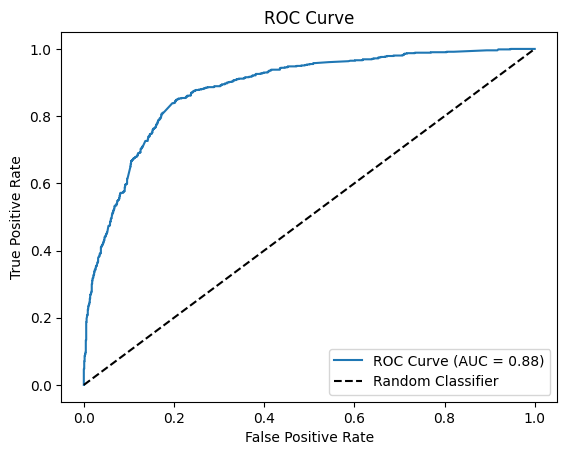

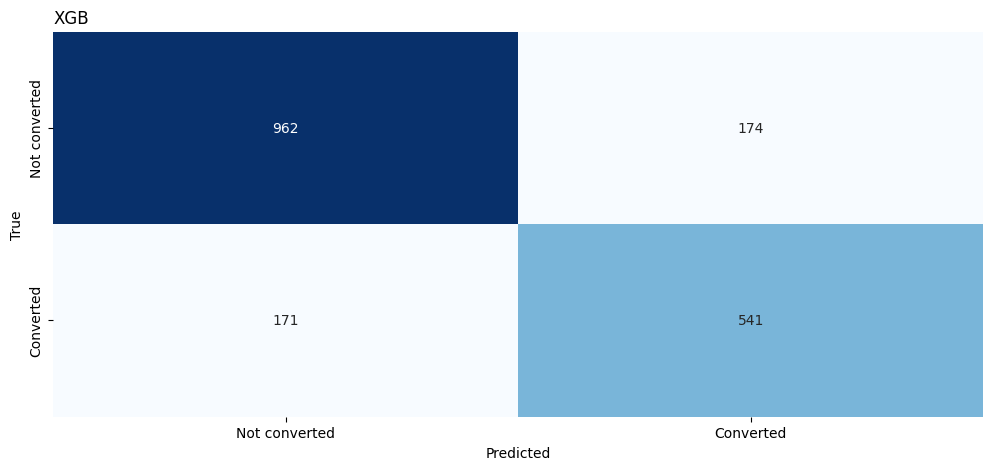

In [14]:
model_classification_report(xgb_model, 'XGB', X_test, y_test)

In [15]:
# Precision and recall curve
xgb_prec, xgb_recall, xgb_threshold = precision_recall_curve(y_train, xgb_pred, pos_label=xgb_model.classes_[1])
xgb_prdisplay = PrecisionRecallDisplay(precision=xgb_prec, recall=xgb_recall)

In [16]:
# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names()

                                              feature  importance
3               pipeline-1__Lead Origin_Lead Add Form    0.501925
50  pipeline-1__What is your current occupation_Wo...    0.071401
49  pipeline-1__What is your current occupation_Un...    0.054561
24           pipeline-1__Last Activity_SMS/Email Sent    0.053716
15                         pipeline-1__Do Not Email_0    0.024228
52            pipeline-2__Total Time Spent on Website    0.018815
21  pipeline-1__Last Activity_Olark Chat Conversation    0.018115
19             pipeline-1__Last Activity_Email Opened    0.012577
17        pipeline-1__Last Activity_Converted to Lead    0.010038
31  pipeline-1__Specialization_Hospitality Management    0.009967
42                 pipeline-1__Specialization_Unknown    0.009809
0                         pipeline-1__Lead Origin_API    0.009604
47  pipeline-1__What is your current occupation_St...    0.009112
2     pipeline-1__Lead Origin_Landing Page Submission    0.009028
4         

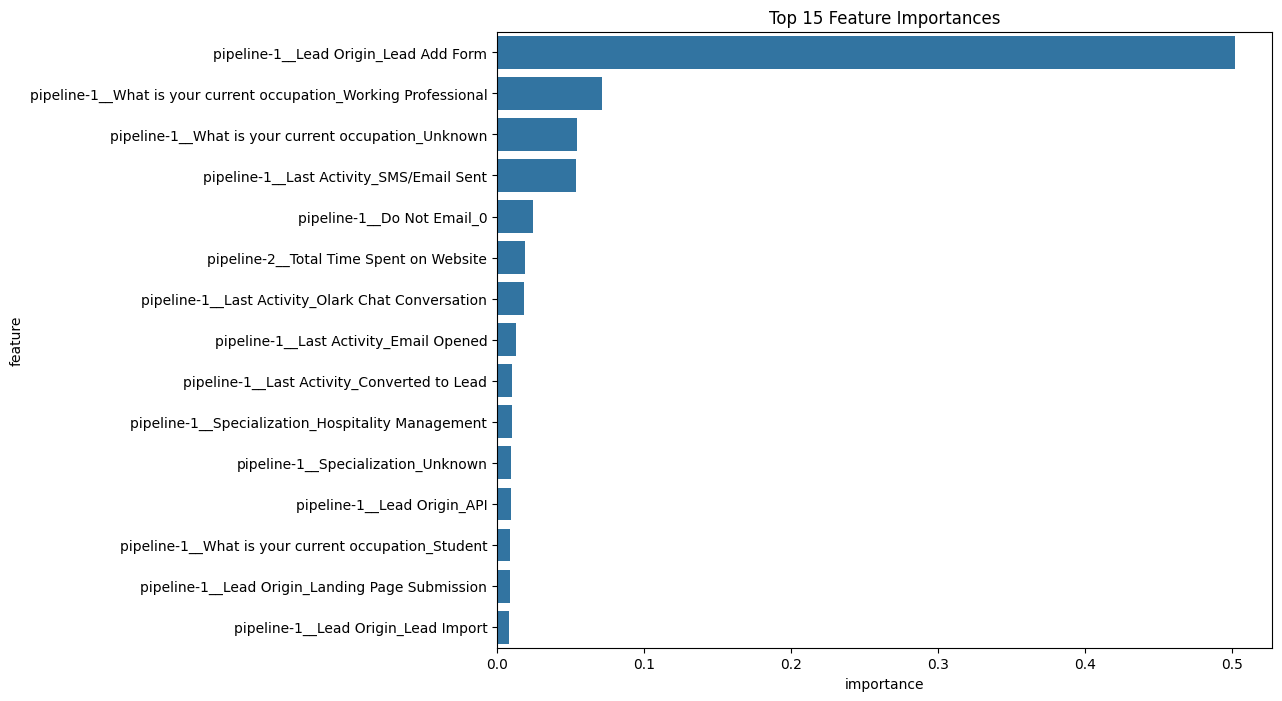

In [17]:
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_ # or best_xgb_model.feature_importances_ if you tuned
}).sort_values('importance', ascending=False)

print(feature_importances)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.show()

### Hyperparameters Tuning
Using `Optuna` and `MLFlow`

In [21]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")


In [22]:
def objective_xgboost(trial):
    """
    Objective function for XGBoost hyperparameter optimization.
    """
    with mlflow.start_run(nested=True):
        # Define hyperparameter search space
        param = {
            "verbosity": 0,
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        }
        
        if param["booster"] == "gbtree" or param["booster"] == "dart":
            param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
            param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
        
        
        mlflow.log_params(param)
        
        # Create model
        model = XGBClassifier(**param)
    
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_train, y_train, 
                            cv=cv, scoring='roc_auc')
    
        mean_score = scores.mean()
        mlflow.log_metric("cv_roc_auc_mean", mean_score)
        mlflow.log_metric("cv_roc_auc_std", scores.std())
        
    
    return mean_score

In [23]:
mlflow.set_experiment("XGBoost Lead Scoring with Optuna")
with mlflow.start_run(run_name="Hyperparameter Tuning Study"):
    # The main parent run for the entire optimization process
    
    # Define a study and optimize the objective function
    # We want to maximize ROC AUC, so direction='maximize'
    study = optuna.create_study(direction="maximize")

    # The optimize method will run the objective function n_trials times
    study.optimize(objective_xgboost, n_trials=50, show_progress_bar=True)
    
    # Log the best parameters and best metric to the parent run
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_roc_auc", study.best_value)

    # Print the best trial results
    print("\nOptimization finished.")
    print(f"Best trial (ROC AUC): {study.best_value}")
    print(f"Best parameters: {study.best_params}")

    # You can get the best model from the best trial's parameters and retrain it on the full data
    best_params = study.best_params
    best_model = XGBClassifier(**best_params, use_label_encoder=False)

2025/08/08 17:35:24 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost Lead Scoring with Optuna' does not exist. Creating a new experiment.
[I 2025-08-08 17:35:24,235] A new study created in memory with name: no-name-ab29ad5f-3502-4d62-be61-dc8e4723ce4c


  0%|          | 0/50 [00:00<?, ?it/s]

🏃 View run placid-calf-816 at: http://127.0.0.1:8080/#/experiments/482914104142622764/runs/cd0a99d5cb32437c88f965fdbcbbf65e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/482914104142622764
[I 2025-08-08 17:35:41,798] Trial 0 finished with value: 0.8214953796165811 and parameters: {'booster': 'dart', 'lambda': 1.8944229578521646e-05, 'alpha': 2.9164052607896202e-08, 'max_depth': 2, 'eta': 0.007699658996211362, 'gamma': 0.0027983857216166063, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.6089589236635677, 'skip_drop': 0.0005982481118700042}. Best is trial 0 with value: 0.8214953796165811.
🏃 View run loud-turtle-684 at: http://127.0.0.1:8080/#/experiments/482914104142622764/runs/2c2c14d8f4824e97be53453483f3a713
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/482914104142622764
[I 2025-08-08 17:36:24,243] Trial 1 finished with value: 0.9058339266340878 and parameters: {'booster': 'dart', 'lambda': 0.001548774140418104

KeyboardInterrupt: 

In [24]:
best_model.fit(X_train, y_train)

NameError: name 'best_model' is not defined

In [31]:
y_pred = best_model.predict(X_test)

## Saving Model and Preprocessor

In [35]:
import joblib

In [36]:
# --- 4. Save the Model and Preprocessor ---
model_filename = 'models/xgb_best_lead_scoring_model.joblib'
preprocessor_filename = 'preprocessor/lead_scoring_preprocessor.joblib'
feature_names_filename = 'models/lead_scoring_feature_names.joblib' # Optional, but very useful

joblib.dump(best_model, model_filename)
joblib.dump(preprocessor, preprocessor_filename)
joblib.dump(feature_names, feature_names_filename) # Save feature names too!

print(f"\nModel saved to: {model_filename}")
print(f"Preprocessor saved to: {preprocessor_filename}")
print(f"Feature names saved to: {feature_names_filename}")


Model saved to: models/xgb_best_lead_scoring_model.joblib
Preprocessor saved to: preprocessor/lead_scoring_preprocessor.joblib
Feature names saved to: models/lead_scoring_feature_names.joblib
